In [1]:
import sys

sys.path.append('../src')

In [2]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm

from data_preparation import get_data
from models import (
    CustomCNN,
    LeNet5BasedModelFor32x32Images,
    PretrainedAlexNet,
    PretrainedResNet,
    PretrainedVGG16,
    ResidualBlock,
    ResNetBasedModelFor32x32Images,
    VGG16BasedModelFor32x32Images,
    WideModel,
)
from train_eval_utils import evaluate_model

MODELS = {
    "CustomCNN": CustomCNN,
    "LeNet5BasedModelFor32x32Images": LeNet5BasedModelFor32x32Images,
    "VGG16BasedModelFor32x32Images": VGG16BasedModelFor32x32Images,
    "ResNetBasedModelFor32x32Images": ResNetBasedModelFor32x32Images,
    "WideModel": WideModel,
}

In [3]:
from pathlib import Path

class Comitee:
    def __init__(self, path:Path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._initialize_models(path)
        
    def _initialize_models(self, path: Path):
        model_paths = os.listdir(path)
        self.models = []

        for model_path in model_paths:
            model_name = model_path.split('_')[0]

            model = (
                MODELS[model_name]()
                if "ResNetBasedModelFor32x32Images" != model_name
                else MODELS[model_name](ResidualBlock, [2, 2, 2, 2])
            )
            checkpoint = torch.load(path / model_path, map_location='cuda:0')
            model.load_state_dict(checkpoint["model_state_dict"])
            model.to(self.device)
            self.models.append(model)
    
    def ensemble_predict(self, input_data):
        predictions = []

        for model in self.models:
            model.eval()
            with torch.no_grad():
                output = model(input_data.to(self.device))
                probabilities = F.softmax(output, dim=1)
                predictions.append(torch.argmax(probabilities, dim=1))
    
        predictions = torch.stack(predictions)
        ensemble_prediction = torch.mode(predictions, dim=0).values.squeeze()

        return ensemble_prediction
        
    def __call__(self, input_data):
        return self.ensemble_predict(input_data)

In [4]:
from sklearn.metrics import confusion_matrix
from utils import save_confusion_matrix

def calculate_accuracy(outputs, labels):
    # _, preds = torch.max(outputs, 1)
    corrects = torch.sum(outputs == labels.data).item()
    return corrects / labels.size(0)

def evaluate_model(device, model, test_loader, save_cm=False, cm_path=None):
    running_accuracy = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(
                device, non_blocking=True
            )
            outputs = model(inputs)

            predictions.append(outputs)
            true_labels.append(labels)
            running_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)

        predictions = torch.cat(predictions)
        true_labels = torch.cat(true_labels)
        # predictions = torch.argmax(predictions, dim=1)
        true_labels = true_labels.cpu().numpy()
        predictions = predictions.cpu().numpy()
        cm = confusion_matrix(true_labels, predictions)
        if save_cm:
            save_confusion_matrix(true_labels, predictions, cm_path)

    test_accuracy = running_accuracy / len(test_loader.dataset)
    return test_accuracy

# With augmentation

In [5]:
comitee = Comitee(Path('augmented/'))

In [6]:
_, _, cinic_test = get_data('..', batch_size=256, augmentation=True)

100%|██████████| 352/352 [00:14<00:00, 23.77it/s]


Test Accuracy: 0.79%


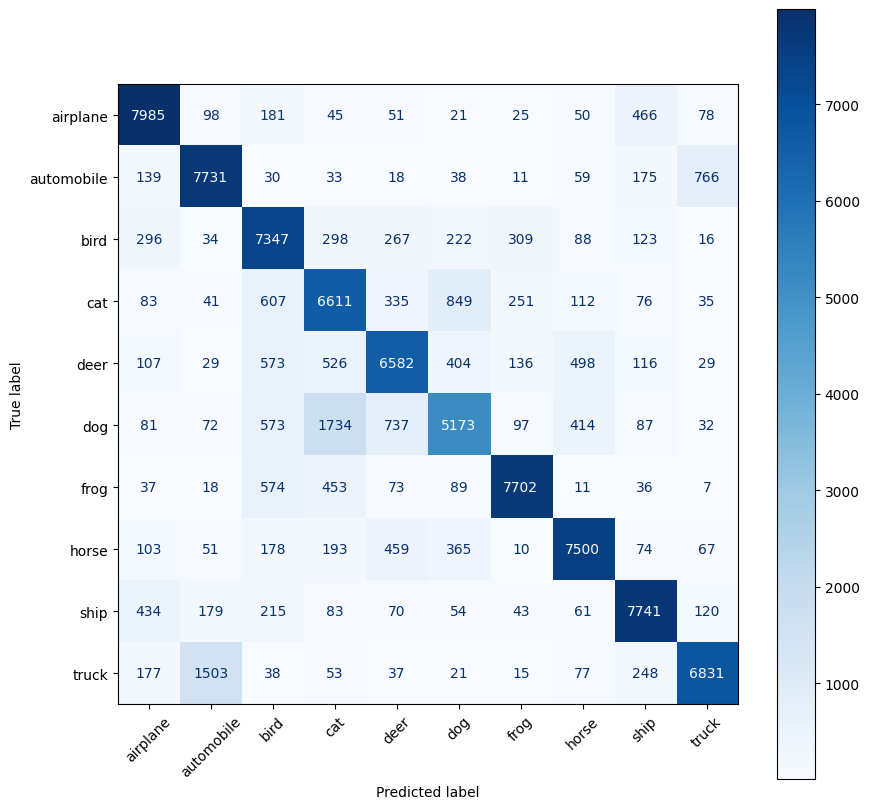

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model
test_accuracy = evaluate_model(device, comitee, cinic_test, save_cm=True, cm_path='augmented.png')
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Without augmentation

In [9]:
comitee = Comitee(Path('not_augmented/'))

In [10]:
_, _, cinic_test = get_data('..', batch_size=256)

100%|██████████| 352/352 [00:12<00:00, 27.18it/s]


Test Accuracy: 0.72%


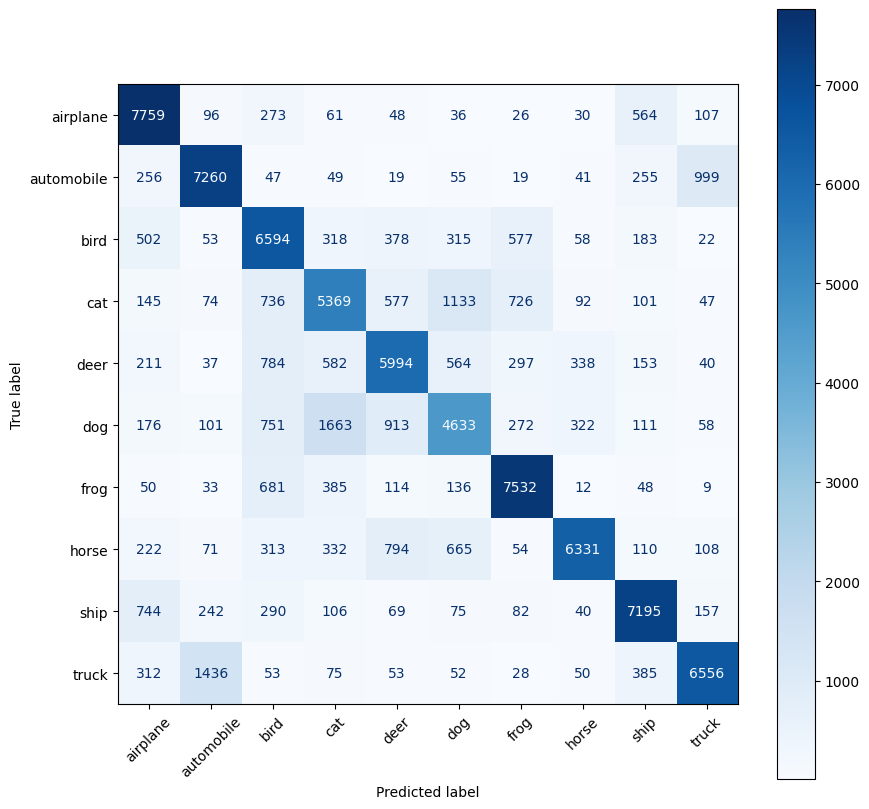

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model
test_accuracy = evaluate_model(device, comitee, cinic_test, save_cm=True, cm_path='not_augmented.png')
print(f"Test Accuracy: {test_accuracy:.2f}%")